In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv(r"C:\Users\jjap2\Poleto SCE\Poleto-SCE\dond_game_data.csv")

In [2]:
#cleaning cell
df["Remaining Values"] = df["Remaining Values"].apply(ast.literal_eval)

all_values = set()
for values in df["Remaining Values"]:
    all_values.update(values)

for value in sorted(all_values):
    df[f"Case_{value}"] = df["Remaining Values"].apply(lambda x: 1 if value in x else 0)

df.drop(columns=["Remaining Values"], inplace=True)
df.drop(columns=["Contestant Name"], inplace=True)

categorical_columns = ["Contestant Gender", "Contestant Race"]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df = df[(df["Postgame"] != 1) & (df["Offer"] != 0)]


In [3]:
# defining variables
X = df.drop(columns=["Offer"])
y = df["Offer"]

In [4]:
# standardize!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

In [6]:
Alpha = lasso.alpha_
lasso_coefs = lasso.coef_

print("Alpha:", Alpha
      )
print("LASSO Coefficients:", lasso_coefs)

Alpha: 149.10096128447432
LASSO Coefficients: [-4.79551170e+02 -5.68897585e+03 -2.99230687e+04  8.04773837e+04
 -0.00000000e+00  6.83435571e+03  3.50738096e+04 -2.15990124e+03
  4.02993881e+03  0.00000000e+00  8.25177624e+03  2.93165288e+03
  2.93301201e+03  2.19541181e+02  2.97889175e+03  2.83622048e+03
 -0.00000000e+00  2.38783968e+03  2.98598286e+03  2.85622104e+03
  6.93387896e+02  2.70416329e+03  2.38654926e+03  1.39138558e+03
  2.71530345e+03  1.01274597e+03  0.00000000e+00  1.33453189e+03
 -0.00000000e+00 -0.00000000e+00  3.76116883e+03  1.83902552e+03
  0.00000000e+00  2.52962100e+03  1.70607747e+03  1.16256094e+03
 -0.00000000e+00  6.59300432e+02 -0.00000000e+00 -2.60043139e+03
  2.64914343e+01  0.00000000e+00  2.21849664e+02  0.00000000e+00
 -1.60613732e+02 -2.74601405e+02 -1.99387753e+03  0.00000000e+00
 -2.85617473e+02 -0.00000000e+00 -7.27649627e+03 -0.00000000e+00
  4.11018310e+02  7.22348272e+02 -5.93179299e+02 -0.00000000e+00]


In [7]:
nz_feats = X.columns[lasso.coef_ != 0]
nz_coefs = lasso.coef_[lasso.coef_ != 0]
nz_feat_list = list(zip(nz_feats, nz_coefs))
nz_feat_list.sort(key=lambda x: abs(x[1]), reverse=True)

print("Important Features and Their LASSO Coefficients:")
for feature, coef in nz_feat_list:
    print(f"{feature}: {coef:.4f}")


Important Features and Their LASSO Coefficients:
Board Average: 80477.3837
Offer Percent of Average: 35073.8096
Board Value: -29923.0687
Probability of Big Value: 8251.7762
Case_6000000: -7276.4963
Previous Offer: 6834.3557
Round: -5688.9758
Amount Won: 4029.9388
Case_5000: 3761.1688
Case_50: 2985.9829
Case_5: 2978.8918
Case_1: 2933.0120
Case_0: 2931.6529
Case_75: 2856.2210
Case_10: 2836.2205
Case_500: 2715.3035
Case_200: 2704.1633
Case_250000: -2600.4314
Case_25000: 2529.6210
Case_25: 2387.8397
Case_300: 2386.5493
Deal: -2159.9012
Case_1000000: -1993.8775
Case_10000: 1839.0255
Case_50000: 1706.0775
Case_400: 1391.3856
Case_1000: 1334.5319
Case_75000: 1162.5609
Case_750: 1012.7460
Contestant Race_Black: 722.3483
Case_100: 693.3879
Case_150000: 659.3004
Contestant Race_Hispanic: -593.1793
Game ID: -479.5512
Contestant Gender_Non-Binary: 411.0183
Case_2000000: -285.6175
Case_800000: -274.6014
Case_500000: 221.8497
Case_2: 219.5412
Case_750000: -160.6137
Case_300000: 26.4914


In [8]:
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

Train MSE: 134598795.06, Test MSE: 230898638.88
Train R²: 0.98, Test R²: 0.97


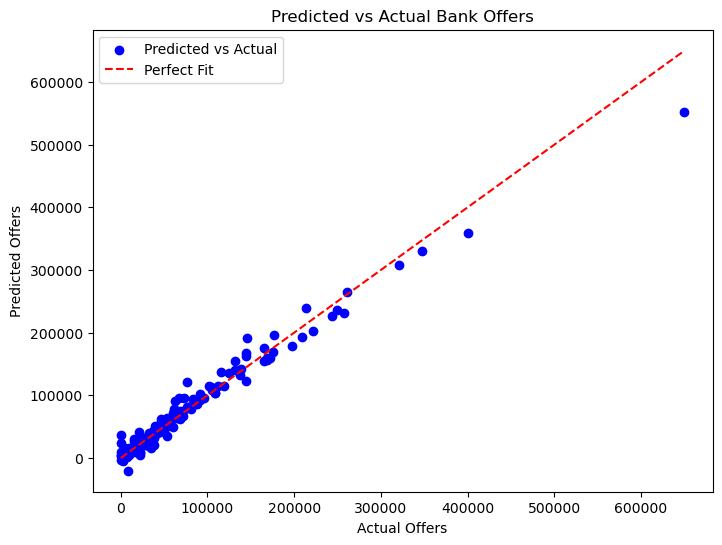

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Offers")
plt.ylabel("Predicted Offers")
plt.title("Predicted vs Actual Bank Offers")
plt.legend()
plt.show()

In [10]:
results = df.loc[y_test.index, ["Game ID", "Round"]].copy()
results["Actual Offer"] = y_test.values
results["Predicted Offer"] = y_test_pred
negative_predictions = results[results["Predicted Offer"] < 0]

print(negative_predictions)


     Game ID  Round  Actual Offer  Predicted Offer
136       24      9         500.0     -3235.908369
821      107      3        8700.0    -20328.091618
376       51      8        3000.0     -5173.944038
